In [ ]:
!pip install wandb

***Importing Libraries and Load Data***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.datasets import mnist
from sklearn.manifold import TSNE
import wandb

# load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
class_type = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] 

proj_name='CS6910 ASSIGNMENT 4'

Logging 1 image from each class

In [ ]:
print("Sample Images for each Class :")
class_list=list()
wandb.init(project=proj_name)
for i in range(10):
  plt.subplot(2,5,i+1)
  for j in range(len(y_train)):
    if y_train[j] == i :
        wandb.log({"img": [wandb.Image(x_train[j], caption=class_type[y_train[j]])]})
        class_list.append(class_type[y_train[j]])
        break

***Modify and Restructure Data***

In [ ]:
# Initializations

# Data
X_train = np.array(x_train.reshape(x_train.shape[0], 784,1))         # reshape 2-D data to 1-D
X_test  = np.array(x_test.reshape(x_test.shape[0], 784,1))           # reshape 2-D data to 1-D
X_train = (X_train > 126) * 1                                        # convert the real valued data into binary data, using a threshold of 127
X_test  = (X_test > 126) * 1                                         # convert the real valued data into binary data, using a threshold of 127

X_val = X_train[-15000:]                                             # validation set input (to train Classifier)
X_train = X_train[0:45000]                                           # training set input (to train RBM)

Y_train = np.zeros([len(y_train),10,1])
Y_test = np.zeros([len(y_test),10,1])

for i in range(len(y_train)):                                        # convert y from just a class number to one hot vector (10x1)
  y = np.zeros([10, 1])
  y[y_train[i]] = 1.0
  Y_train[i] = y

for i in range(len(y_test)):                                         # convert y from just a class number to one hot vector (10x1)
  y = np.zeros([10, 1])
  y[y_test[i]] = 1.0
  Y_test[i] = y                                                      # test set output

Y_val = Y_train[-15000:]                                             # validation set output
Y_train = Y_train[0:45000]                                           # training set output

***Hyperparameters and Basic variables***

In [ ]:
n_visible = X_train.shape[1]                                         # number of visible neurons
n_train_examples = X_train.shape[0]                                  # number of training data
n_val_examples = X_val.shape[0]                                      # number of validation data
n_test_examples = X_test.shape[0]                                    # number of test data
n_hidden = 80                                                        # number of hidden neurons
n_class = 10



***Parameter Initialization (Weights and Biases)***

In [ ]:
def rbm_param_init() :                                                                        # Function to randomly initialize the RBM network parameters 
	
  rbm_parameters = {}
  rbm_parameters["W"] = np.random.randn(n_hidden, n_visible)*np.sqrt(6./(n_visible + n_hidden))   # Xavier Initialization of weights
  rbm_parameters["h_bias"] = np.zeros((n_hidden,1),dtype=np.float64)                                                     
  rbm_parameters["v_bias"] = np.zeros((n_visible,1),dtype=np.float64)

  return rbm_parameters

def classifier_param_init() :                                                                 # Function to randomly initialize the Classifier network parameters

  classifier = {}
  classifier["W"] = np.random.randn(n_class, n_hidden)*np.sqrt(6./(n_class + n_hidden))       # Xavier Initialization of weights
  classifier["b"] = np.zeros((n_class,1),dtype=np.float64)

  return classifier

def sigmoid(x) :                                                                              # RBM hidden layer activation function 
	
  return 1.0/(1.0+np.exp(-x))

def softmax(x):                                                                               # Output activation function
    
  return np.exp(x) / np.sum(np.exp(x))  

***RBM and Classifier Trainer***

In [ ]:
def rbm_train(X_train,parameters,k,learning_rate) :                                     # Function to train the RBM
	
  W = parameters["W"]
  h_bias = parameters["h_bias"]
  v_bias = parameters["v_bias"]
  
  #batches = n_examples // batchsize
  
  for i in range(n_train_examples) :
      v_sample = X_train[i]
      v_init   = X_train[i]

      for t in range(k) :                                                               # Markov Chain - Loop
         h_given_v = sigmoid(np.dot(W,v_sample)+h_bias)                                  # Evaluate p(h|v)
         h_sample = np.random.binomial(1,h_given_v)                                      # Convert to 0's and 1's assuming binomial distribution p(h|v) 
         v_given_h = sigmoid(np.dot(np.transpose(W),h_sample)+v_bias)                    # Evaluate p(v|h)
         v_sample = np.random.binomial(1,v_given_h)                                      # Convert to 0's and 1's assuming binomial distribution p(v|h)

      # Update Rule
      W = W + learning_rate*(np.dot(sigmoid(np.dot(W,v_init)+h_bias),np.transpose(v_init)) - np.dot(sigmoid(np.dot(W,v_sample)+h_bias),np.transpose(v_sample)))
      v_bias = v_bias + learning_rate*(v_init-v_sample)
      h_bias = h_bias + learning_rate*(sigmoid(np.dot(W,v_init)+h_bias) - sigmoid(np.dot(W,v_sample)+h_bias))

  parameters["W"] = W
  parameters["h_bias"] = h_bias
  parameters["v_bias"] = v_bias
  print("Training Complete")

  return parameters


def get_hidden(x,parameters) :                                                                # function to get the hidden representation of the test data
   
    W = parameters["W"]
    h_bias = parameters["h_bias"]
    hidden_prob = sigmoid(np.dot(W,x)+h_bias)
    hidden_rep = np.random.binomial(1,hidden_prob)
    
    return hidden_rep

def classifier_train(X,Y,rbm_parameters,classifier_param,classifier_epochs,learning_rate)  :                                  # Function to train Classifier
    
    W = classifier_param["W"]
    b = classifier_param["b"]
    
    for epoch in range(classifier_epochs) :
      for i in range(n_val_examples) :
         # feed forward
         hidden_rep = get_hidden(X[i],rbm_parameters)                                         # Obtain hidden representation for the given sample
         pre_output = np.dot(W,hidden_rep)+b
         y_hat = softmax(pre_output)
         # backpropogate
         dW = np.dot(-(Y[i]-y_hat),np.transpose(hidden_rep))
         db = -(Y[i]-y_hat)
         # Update Classifier weights
         W = W - learning_rate*dW
         b = b - learning_rate*db

    classifier_param["W"] = W
    classifier_param["b"] = b 
    
    return classifier_param   


In [ ]:
def rbm_classifier(X_train,Y_train,X_val,Y_val,X_test,Y_test,rbm_epochs,classifier_epochs,k,n_hidden,learning_rate) :

  classifier_param = classifier_param_init() 
  rbm_parameters = rbm_param_init()

  for j in range(rbm_epochs) :

     rbm_parameters = rbm_train(X_train,rbm_parameters,k,learning_rate)                             # Train RBM for one epoch
     classifier_param = classifier_train(X_val,Y_val,rbm_parameters,classifier_param,classifier_epochs,learning_rate)               # Train the classifier with hidden representation of RBM
     
     accuracy = 0.0
     loss = 0.0 
     # Evaluate accuracy and loss over test data

     for i in range(n_test_examples) :

        h = get_hidden(X_test[i],rbm_parameters)
        y_hat = softmax(np.dot(classifier_param["W"],h)+classifier_param["b"])

        if y_hat.argmax()==Y_test[i].argmax():
            accuracy = accuracy + 1
        loss = loss + -1*np.sum(np.multiply(y,np.log(y_hat)))

     accuracy = accuracy/n_test_examples
     loss = loss/n_test_examples 
     print("Epoch :" + str(j)+" "+ str(accuracy)+" "+str(loss))
    # wandb.log({"Accuracy":accuracy,"Loss":loss,"Epoch":j})

  return rbm_parameters,classifier_param
      

	

In [ ]:
def train():
  hyperparameter_defaults=dict(
        rbm_epochs = 20,
        classifier_epochs = 1,
        k = 2,
        n_hidden = 256,
        learning_rate = 0.001                                                                    
        )

  wandb.init(config=hyperparameter_defaults)

  config=wandb.config
  rbm_parameters,classifier_param = rbm_classifier(X_train,Y_train,X_val,Y_val,X_test,Y_test,config.rbm_epochs,config.classifier_epochs,config.k,config.n_hidden,config.learning_rate)




In [ ]:
def sweeper(sweep_config,proj_name):
  sweep_id = wandb.sweep(sweep_config,project=proj_name,entity='cs6910krsrd',)
  wandb.agent(sweep_id,train,project=proj_name,entity='cs6910krsrd',)

In [ ]:
#sweep dictionary
sweep_config={
    'method':'bayes',
    'metric':{
        'name':'accuracy',
        'goal':'maximize'},

}

parameters_dict={
    
    'rbm_epochs':{
      'values':[20]  
    },
    'classifier_epochs':{
        'values':[1]
    },
    'k':{
        'values':[20]
    },
    'n_hidden':{
        'values':[64]      #,128,256]
    },
    'learning_rate':{
        'values':[0.01]
    }
    
}

sweep_config['parameters']=parameters_dict

In [ ]:
sweeper(sweep_config,proj_name)

***Training over Best Model***

We train the RBM-Classifier Model over the estimated best hyperparameters (obtained from WandB sweep) and present the evolution of Accuracy and Loss over each epoch.

In [ ]:
rbm_epochs = 20
classifier_epochs = 1
k = 2
n_hidden = 256
learning_rate = 0.001

rbm_parameters,classifier_param = rbm_classifier(X_train,Y_train,X_val,Y_val,X_test,Y_test,rbm_epochs,classifier_epochs,k,n_hidden,learning_rate)


Training Complete
Epoch :0 0.6781 4.912716309037713
Training Complete
Epoch :1 0.7219 5.418884163064235
Training Complete
Epoch :2 0.733 5.765258281272607
Training Complete
Epoch :3 0.7413 6.007872412237866
Training Complete
Epoch :4 0.7466 6.222961755360926
Training Complete
Epoch :5 0.7504 6.421010149304638
Training Complete
Epoch :6 0.76 6.5031654558371885
Training Complete
Epoch :7 0.7576 6.695289288218057
Training Complete
Epoch :8 0.7697 6.759407754133709
Training Complete
Epoch :9 0.7729 6.95707965677313
Training Complete
Epoch :10 0.773 7.022360640800791
Training Complete
Epoch :11 0.7756 7.097541717314903
Training Complete
Epoch :12 0.7741 7.278622521184037
Training Complete
Epoch :13 0.7784 7.3421021454282585
Training Complete
Epoch :14 0.7786 7.355222418910626
Training Complete
Epoch :15 0.7786 7.459474254307884
Training Complete
Epoch :16 0.7769 7.524442643431746
Training Complete
Epoch :17 0.7831 7.629010142236037
Training Complete
Epoch :18 0.7801 7.622094226125462
Traini


***Contrastive Divergence Results***

For the best RBM-Classifier Model, the hyperparameters are 
    

*   n_hidden neurons = 256
*   number of Markov steps = 2
*   learning rate = 0.01

The accuracy achieved over test-data is 78.26% after 20 epochs of training RBM-Classifier Model.





***Visualising Hidden Representation using t-SNE Plot*** 

In [ ]:
from sklearn.manifold import TSNE

hidden_reps = []

for i in range(n_test_examples) :
  
    h = get_hidden(X_test[i],rbm_parameters)
    hidden_reps.append(np.array(h))

print(np.shape(hidden_reps))

hidden_reps = np.array(hidden_reps)
hidden_reps = np.resize(hidden_reps, (n_test_examples,256))
embedded = TSNE(n_components = 2, early_exaggeration = 7).fit_transform(hidden_reps)           # n_components = Dimension of the embedded space (here 2D).

vis_x = embedded[:,0]
vis_y = embedded[:,1]


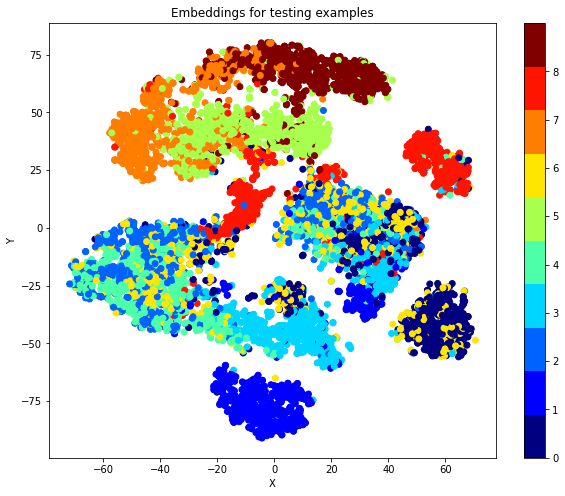

In [ ]:
run = wandb.init(project=PROJECT_NAME)


plt.figure(figsize = (10,8))
plt.title("Embeddings for testing examples")
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(vis_x[:10000], vis_y[:10000], c = y_test[:10000], cmap = plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks = range(max(y_test)))
wandb.log({"embPlot": plt})
plt.show()
class_type = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

run.finish()

***Visualise the samples generated from the distribution***

Epoch : 0


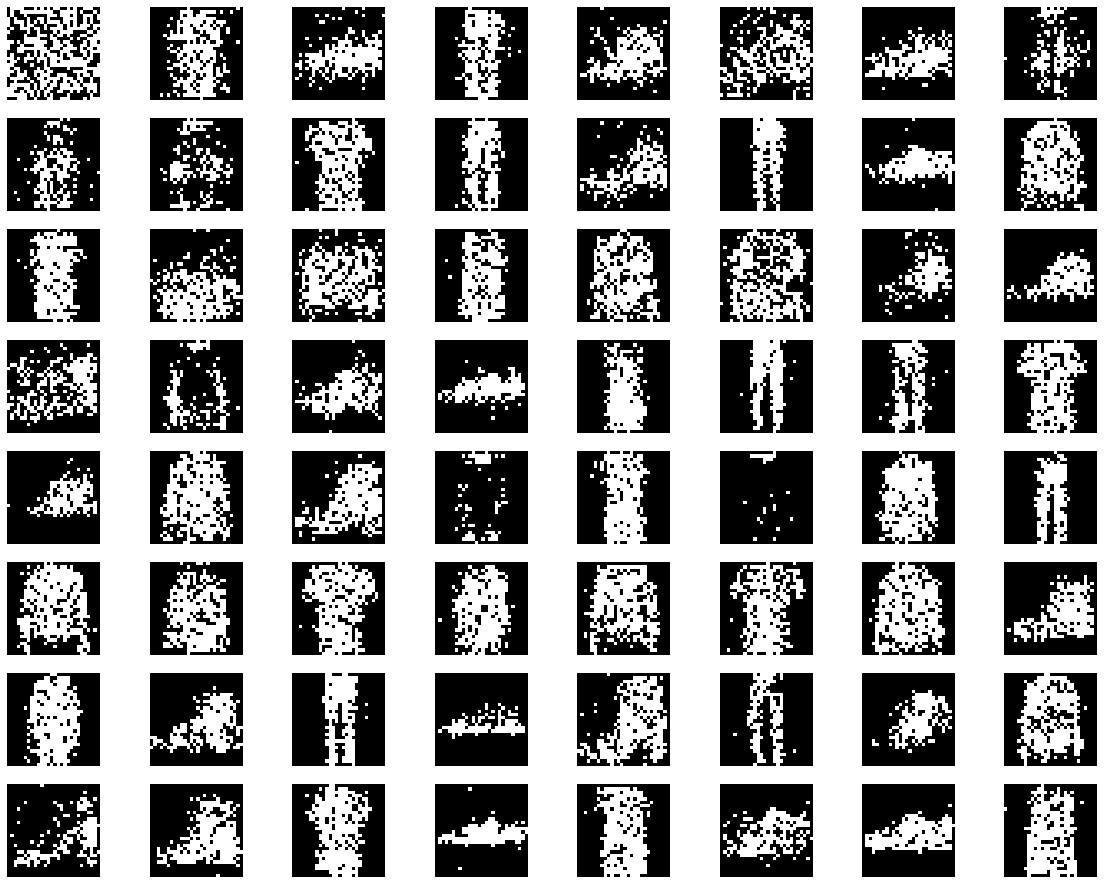

Epoch : 1
Epoch : 2
Epoch : 3
Epoch : 4
Epoch : 5
Epoch : 6
Epoch : 7
Epoch : 8
Epoch : 9


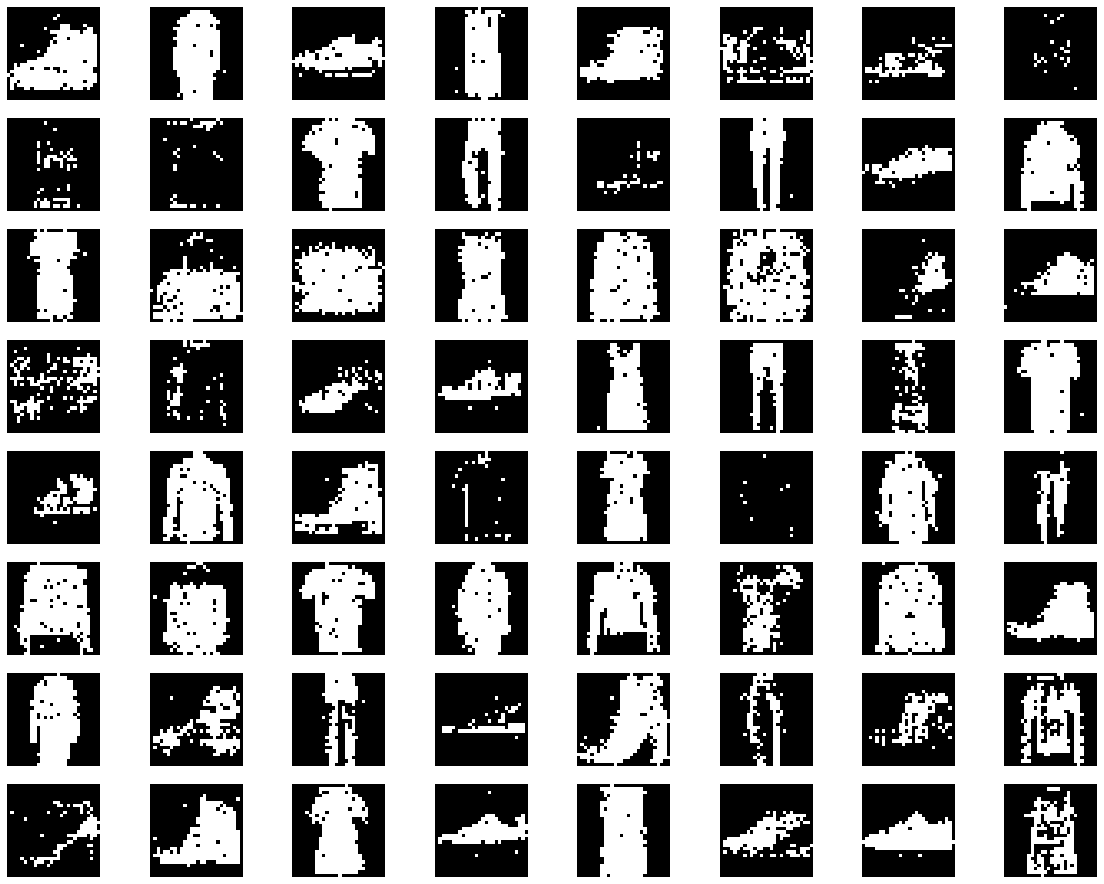

Training Complete


In [ ]:
  run = wandb.init(project=PROJECT_NAME)


  rbm_parameters = rbm_param_init()
  rbm_epochs = 18

  W = rbm_parameters["W"]
  h_bias = rbm_parameters["h_bias"]
  v_bias = rbm_parameters["v_bias"]

  for j in range(rbm_epochs) :

      if (j==0) or (j==9) :
          plt.figure(figsize = (10,8))
          subplot_no = 1
          
      for i in range(n_train_examples) :
          v_sample = X_train[i]
          v_init   = X_train[i]

          if ((j==0) or (j==9)) and ((i%(701) == 0)) and (subplot_no <= 64):

            hidden = np.random.binomial(1,sigmoid(np.dot(W,v_sample)+h_bias))
            img_reconstruct = np.random.binomial(1,sigmoid(np.dot(np.transpose(W),hidden)+v_bias))
            img = np.reshape(img_reconstruct, (28,28))
            plt.subplot(8,8,subplot_no)
            plt.imshow(img, cmap = "gray")
            plt.axis("off")
            subplot_no += 1

          for t in range(k) :                                                                # Markov Chain - Loop
             h_given_v = sigmoid(np.dot(W,v_sample)+h_bias)                                  # Evaluate p(h|v)
             h_sample = np.random.binomial(1,h_given_v)                                      # Convert to 0's and 1's assuming binomial distribution p(h|v) 
             v_given_h = sigmoid(np.dot(np.transpose(W),h_sample)+v_bias)                    # Evaluate p(v|h)
             v_sample = np.random.binomial(1,v_given_h)                                      # Convert to 0's and 1's assuming binomial distribution p(v|h)

          # Update Rule
          W = W + learning_rate*(np.dot(sigmoid(np.dot(W,v_init)+h_bias),np.transpose(v_init)) - np.dot(sigmoid(np.dot(W,v_sample)+h_bias),np.transpose(v_sample)))
          v_bias = v_bias + learning_rate*(v_init-v_sample)
          h_bias = h_bias + learning_rate*(sigmoid(np.dot(W,v_init)+h_bias) - sigmoid(np.dot(W,v_sample)+h_bias))


      if (j==0) or (j==9) :
        wandb.log({"Sample Visualisation": plt})


      plt.show()

  rbm_parameters["W"] = W
  rbm_parameters["h_bias"] = h_bias
  rbm_parameters["v_bias"] = v_bias
  print("Training Complete")

  run.finish()
